# Analiza Koncentracije PM2.5 Čestica u Šangaju
### Prepoznavanje Oblika - Domaci 1
### Đorđe Stanković, IN13-2018

In [189]:
# Ucitavanje biblioteka i funkcija
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import datasets

## Pregled Baze Podataka

• No: redni broj vrste\
• year: godina\
• month: mesec\
• day: dan u mesecu\
• hour: sat u danu\
• season: godišnje doba\
• PM: koncentracija PM2.5 čestica na nekoliko lokacija (ug/m3)\
• DEWP: temperatura rose/kondenzacije (stepeni Celzijusa)\
• HUMI: vlažnost vazduha (%)\
• PRES: vazdušni pritisak (hPa)\
• TEMP: temperatura (stepeni Celzijusa)\
• cbwd: pravac vetra (N-sever, S-jug, E-istok, W-zapad, cv-calm/variable)\
• Iws: brzina vetra (m/s)\
• precipitation: padavine na sat (mm)\
• Iprec: ukupne padavine (mm), odnosno kumulativna suma padavina po satima dok ne prestanu padavine.

In [190]:
df = pd.read_csv('ShanghaiPM20100101_20151231.csv')
df.drop(labels = ["No", "PM_Jingan", "PM_Xuhui"], axis=1, inplace=True)
df.head()
print("Baza ima", df.shape[0], "uzoraka i", df.shape[1],"obelezja.")

Baza ima 52584 uzoraka i 14 obelezja.


Baza ima 52584 uzoraka i 17 obelezja.\
Uzorak baze predstavlja casovno merenje senzora za kvalitet vazduha.\
Kategoricka obelezja su No, Year, Month, Day, Hour, Season i cbwd.\
Numericka obelezja su PM, DEWP, HUMI, PRES, TEMP, Iws, precipitation i Iprec.\
No, PM_jingan i PM_Xuhui su nepotrebna obelezja, i mozemo da ih izbacimo.

In [191]:

df.columns=["Year","Month","Day","Hour","Season","PM (ug/m3)", "Dew Temp (C)", "Humidity (%)","Pressure (hPa)","Temperature (C)","Wind Direction","Wind Speed (m/s)","Precipitation (mm)", "TotalPrec (mm)"]
df.describe().round(2).drop(["Year", "Month", "Day", "Hour", "Season"], axis=1)

,PM (ug/m3),Dew Temp (C),Humidity (%),Pressure (hPa),Temperature (C),Wind Speed (m/s),Precipitation (mm),TotalPrec (mm)
count,34039.00,52571.00,52571.00,52556.00,52571.00,52572.00,48575.00,48575.00
mean,52.91,11.30,69.55,1016.02,17.47,49.60,0.14,0.94
std,42.58,9.88,17.66,9.02,9.32,78.28,1.07,6.59
min,1.00,-21.00,11.32,990.00,-5.00,0.00,0.00,0.00
25%,26.00,3.00,57.93,1008.10,10.00,6.00,0.00,0.00
50%,41.00,12.00,72.42,1016.00,18.00,20.00,0.00,0.00
75%,67.00,20.00,83.37,1023.00,25.00,61.00,0.00,0.00
max,730.00,28.00,100.00,1040.00,41.00,1110.00,61.60,226.40


In [192]:
df.isnull().sum()

Year                      0
Month                     0
Day                       0
Hour                      0
Season                    0
PM (ug/m3)            18545
Dew Temp (C)             13
Humidity (%)             13
Pressure (hPa)           28
Temperature (C)          13
Wind Direction           12
Wind Speed (m/s)         12
Precipitation (mm)     4009
TotalPrec (mm)         4009
dtype: int64

Year, Month, Day, Hour i Season obelezja imaju ocekivane statistike i nemaju nedostajuce vrednosti.\
Obelezje PM (US) ima NaN vrednosti sve do 17443. uzorka, ali se i kasnije pojavljuju.\
Svi uzorci do 17443. ce biti izbaceni pri kreiranju regresora.\
Dew Temp, Humidity, Pressure i Temperature imaju ocekivane statistike, ali imaju nedostajuce vrednosti.\
Wind Direction je kategoricko obelezje obelezeno string-ovima, i ima nedostajuce vrednosti.\
U slucaju ukljucivanja obelezja u regresiju, obelezje treba biti prebaceno u numericke vrednosti.\
Wind Speed ispada da je kumulativan, sto znaci da je maksimum od 1110 m/s ipak validna vrednost (iako su uragani zabelezeni na oko 40 m/s). Takodje, ima nedostajuce vrednosti.\
Precipitation i TotalPrec imaju ocekivane statistike (maksimum od 61.6 mm je odgovarajuci), ali imaju nedostajuce vrednosti.\
Padavine mogu da imaju NaN vrednost, ali to ne znaci da tog dana nije bilo padavina.

TODO :\
\- Uzorke do 17443. mozemo da izbacimo jer nemaju vrednosti za obelezje PM.\
Nakon ove izmene, baza ce imati 35142 uzoraka, i krece od 28.12.2011. godine.\
\- Popraviti NaN vrednosti za PM, Dew Temp, Humidity, Pressure, Temperature, Wind Direction, Wind Speed. Sve NaN vrednosti mogu da se zamene '`ffill`' metodom, odnosno, mozemo da uzmemo vrednost od prethodnog sata jer se NaN vrednosti ne ponavljaju uzastopno. I Wind Speed i TotalPrec mogu da se fill-uju sa '`ffill`' jer su kumulativni, to ne pravi problem.\
\- Prebaciti Wind Direction u numericke vrednosti. CV, odnosno Calm/Variable moze da bude obelezeno sa 0, ostali od 1 do 4.

In [193]:
# Pokreni samo jednom! PM treba da ima 1103 NaN vrednosti.
df.drop(df.iloc[0:17442].index, axis = 0, inplace = True)
print(df.isnull().sum())
df.head()
print("Baza ima", df.shape[0], "uzoraka i", df.shape[1],"obelezja.")

Year                     0
Month                    0
Day                      0
Hour                     0
Season                   0
PM (ug/m3)            1103
Dew Temp (C)             5
Humidity (%)             5
Pressure (hPa)          20
Temperature (C)          5
Wind Direction           4
Wind Speed (m/s)         4
Precipitation (mm)    2272
TotalPrec (mm)        2272
dtype: int64
Baza ima 35142 uzoraka i 14 obelezja.


In [194]:
df["PM (ug/m3)"].fillna(method="ffill", inplace=True)
df["Dew Temp (C)"].fillna(method="ffill", inplace=True)
df["Humidity (%)"].fillna(method="ffill", inplace=True)
df["Pressure (hPa)"].fillna(method="ffill", inplace=True)
df["Temperature (C)"].fillna(method="ffill", inplace=True)
df["Wind Direction"].fillna(method="ffill", inplace=True)
df["Wind Speed (m/s)"].fillna(method="ffill", inplace=True)
df["Precipitation (mm)"].fillna(method="ffill", inplace=True)
df["TotalPrec (mm)"].fillna(method="ffill", inplace=True)
print(df.isnull().sum())

Year                  0
Month                 0
Day                   0
Hour                  0
Season                0
PM (ug/m3)            0
Dew Temp (C)          0
Humidity (%)          0
Pressure (hPa)        0
Temperature (C)       0
Wind Direction        0
Wind Speed (m/s)      0
Precipitation (mm)    0
TotalPrec (mm)        0
dtype: int64


In [195]:
df.loc[df["Wind Direction"] == "cv", "Wind Direction"] = 0
df.loc[df["Wind Direction"] == "NW", "Wind Direction"] = 1
df.loc[df["Wind Direction"] == "NE", "Wind Direction"] = 2
df.loc[df["Wind Direction"] == "SE", "Wind Direction"] = 3
df.loc[df["Wind Direction"] == "SW", "Wind Direction"] = 4
df.head()

,Year,Month,Day,Hour,Season,PM (ug/m3),Dew Temp (C),Humidity (%),Pressure (hPa),Temperature (C),Wind Direction,Wind Speed (m/s),Precipitation (mm),TotalPrec (mm)
17442,2011,12,28,18,4,36.0,4.0,62.00,1027.1,11.0,2,8.0,0.0,0.0
17443,2011,12,28,19,4,41.0,4.0,62.00,1027.1,11.0,2,9.0,0.0,0.0
17444,2011,12,28,20,4,44.0,5.0,71.07,1028.1,10.0,2,11.0,0.0,0.0
17445,2011,12,28,21,4,40.0,5.0,71.07,1028.1,10.0,2,13.0,0.0,0.0
17446,2011,12,28,22,4,25.0,6.0,76.18,1028.1,10.0,2,15.0,0.0,0.0


In [196]:
df.describe().round(2).drop(["Year", "Month", "Day", "Hour", "Season"], axis=1)

,PM (ug/m3),Dew Temp (C),Humidity (%),Pressure (hPa),Temperature (C),Wind Speed (m/s),Precipitation (mm),TotalPrec (mm)
count,35142.00,35142.00,35142.00,35142.00,35142.00,35142.00,35142.00,35142.00
mean,52.71,11.45,69.90,1015.87,17.56,49.45,0.15,1.00
std,42.34,9.67,17.80,9.03,9.18,71.64,1.06,7.31
min,1.00,-17.00,13.09,990.00,-4.00,0.00,0.00,0.00
25%,26.00,3.00,58.17,1008.00,10.00,6.00,0.00,0.00
50%,41.00,12.00,72.96,1016.00,19.00,20.00,0.00,0.00
75%,67.00,20.00,83.60,1023.00,25.00,62.00,0.00,0.00
max,730.00,28.00,100.00,1040.00,41.00,691.00,61.60,226.40


Podaci su sada uredjeni, mozemo poceti sa analizom obelezja.
## Analiza Obelezja

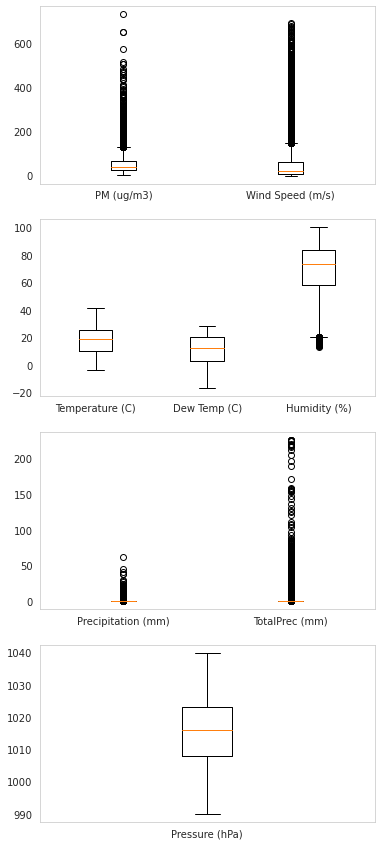

In [198]:
plt.figure(figsize=(6,15))
plt.subplot(4, 1, 1)
plt.boxplot([df["PM (ug/m3)"], df["Wind Speed (m/s)"]])
plt.xticks([1, 2], ["PM (ug/m3)", "Wind Speed (m/s)"])
plt.grid()

plt.subplot(4, 1, 2)
plt.boxplot([df["Temperature (C)"], df["Dew Temp (C)"], df["Humidity (%)"]])
plt.xticks([1, 2, 3], ["Temperature (C)", "Dew Temp (C)", "Humidity (%)"])
plt.grid()

plt.subplot(4, 1, 3)
plt.boxplot([df["Precipitation (mm)"], df["TotalPrec (mm)"]])
plt.xticks([1, 2], ["Precipitation (mm)", "TotalPrec (mm)"])
plt.grid()

plt.subplot(4, 1, 4)
plt.boxplot([df["Pressure (hPa)"]])
plt.xticks([1], ["Pressure (hPa)"])
plt.grid()

plt.savefig("boxplots.png")

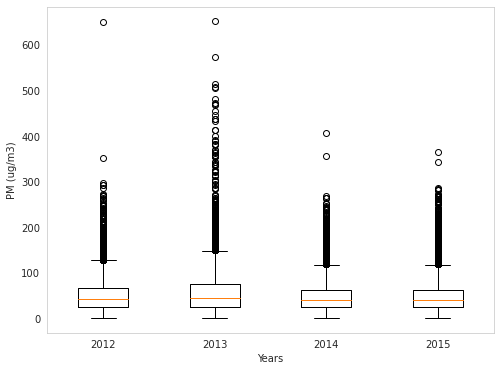

In [199]:
plt.figure(figsize=(8,6))
plt.grid()
plt.xlabel("Years")
plt.ylabel("PM (ug/m3)")
pm2012 = df.loc[df["Year"]==2012]["PM (ug/m3)"]
pm2013 = df.loc[df["Year"]==2013]["PM (ug/m3)"]
pm2014 = df.loc[df["Year"]==2014]["PM (ug/m3)"]
pm2015 = df.loc[df["Year"]==2015]["PM (ug/m3)"]
plt.boxplot([pm2012,pm2013,pm2014,pm2015])
plt.xticks([1,2,3,4], ["2012","2013","2014","2015"])
plt.savefig("pmcompare.png")

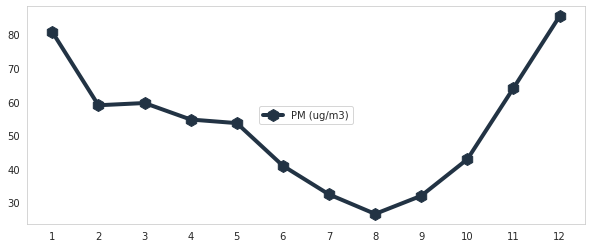

In [200]:
x = df.groupby("Month").mean()
plt.figure(figsize=(10,4))
plt.plot(x["PM (ug/m3)"], linewidth=4, color="#223344", marker="h", markersize=12, label="PM (ug/m3)")
plt.xticks(x.index)
plt.grid()
plt.legend(loc="center")
plt.savefig("monthlypm.png")

/home/stankovictab/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/stankovictab/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/stankovictab/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

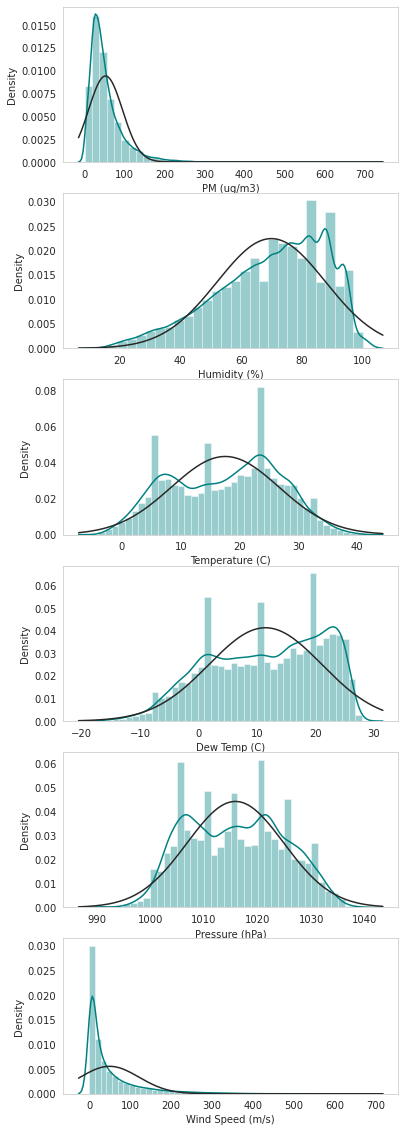

In [201]:
plt.figure(figsize = (6,20))
plt.subplot(6,1,1)
sb.distplot(df["PM (ug/m3)"], bins=40, fit=norm, color="teal")
plt.grid()
plt.subplot(6,1,2)
sb.distplot(df["Humidity (%)"], bins=28, fit=norm, color="teal")
plt.grid()
plt.subplot(6,1,3)
sb.distplot(df["Temperature (C)"], bins=40, fit=norm, color="teal")
plt.grid()
plt.subplot(6,1,4)
sb.distplot(df["Dew Temp (C)"], bins=40, fit=norm, color="teal")
plt.grid()
plt.subplot(6,1,5)
sb.distplot(df["Pressure (hPa)"], bins=40, fit=norm, color="teal")
plt.grid()
plt.subplot(6,1,6)
sb.distplot(df["Wind Speed (m/s)"], bins=50, fit=norm, color="teal")
plt.grid()
plt.savefig("raspodele.png")

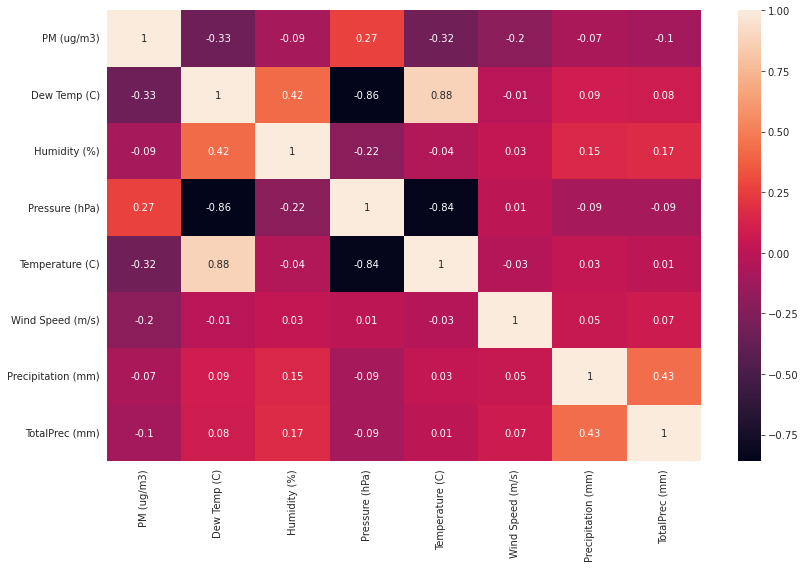

In [202]:
y = df.drop(["Year", "Month", "Day", "Hour", "Season"], axis=1)
corrMatrix = y.corr().round(2)
plt.figure(figsize=(12,8))
sb.heatmap(corrMatrix, annot=True)
plt.tight_layout()
plt.savefig("corrMatrix.png")

Count :
Wind Direction
0     1330
1     6530
2    13273
3     9984
4     4025
Name: PM (ug/m3), dtype: int64

Mean :
0 72.98345864661654
1 76.0249617151608
2 43.27687787237249
3 42.61398237179487
4 64.36546583850932


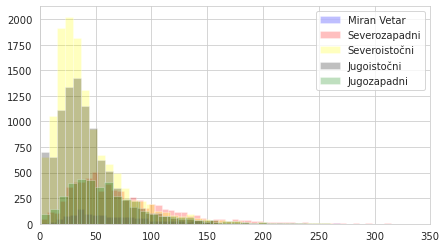

In [203]:
plt.figure(figsize=(7,4))

print("Count :")
gb = df.groupby("Wind Direction").count()
print(gb["PM (ug/m3)"])
print()

print("Mean :")
cv = df.loc[df["Wind Direction"]==0]["PM (ug/m3)"].mean()
print(0, cv)
wd1 = df.loc[df["Wind Direction"]==1]["PM (ug/m3)"].mean()
print(1, wd1)
wd2 = df.loc[df["Wind Direction"]==2]["PM (ug/m3)"].mean()
print(2, wd2)
wd3 = df.loc[df["Wind Direction"]==3]["PM (ug/m3)"].mean()
print(3, wd3)
wd4 = df.loc[df["Wind Direction"]==4]["PM (ug/m3)"].mean()
print(4, wd4)

plt.hist(df.loc[df["Wind Direction"]==0]["PM (ug/m3)"], alpha=0.25, color="blue", bins=90, label="Miran Vetar")
plt.hist(df.loc[df["Wind Direction"]==1]["PM (ug/m3)"], alpha=0.25, color="red", bins=90, label="Severozapadni")
plt.hist(df.loc[df["Wind Direction"]==2]["PM (ug/m3)"], alpha=0.25, color="yellow", bins=90, label="Severoistočni")
plt.hist(df.loc[df["Wind Direction"]==3]["PM (ug/m3)"], alpha=0.25, color="black", bins=90, label="Jugoistočni")
plt.hist(df.loc[df["Wind Direction"]==4]["PM (ug/m3)"], alpha=0.25, color="green", bins=90, label="Jugozapadni")
plt.xlim((0,350))
plt.legend()
plt.savefig("winddirection.png")

## Linearna Regresija

Klasa za računanje mere uspešnosti regresora je kopirana sa vežbi.\
Klase linearne regresije su izvedene iz SciKit Learn paketa.\
Ridge regresor se pravi sa uzorcima koji su standardizovani od strane StandardScaler klase, i sa parametrima koji su prošireni do kvadrata, preko PolynomialFeatures klase.

In [204]:
def model_evaluation(y, y_predicted, N, d):
    mse = mean_squared_error(y_test, y_predicted) # np.mean((y_test-y_predicted)**2)
    mae = mean_absolute_error(y_test, y_predicted) # np.mean(np.abs(y_test-y_predicted))
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_predicted)
    r2_adj = 1-(1-r2)*(N-1)/(N-d-1)

    # printing values
    print('Mean squared error: ', mse)
    print('Mean absolute error: ', mae)
    print('Root mean squared error: ', rmse)
    print('R2 score: ', r2)
    print('R2 adjusted score: ', r2_adj)
    
    # Uporedni prikaz nekoliko pravih i predvidjenih vrednosti
    res=pd.concat([pd.DataFrame(y.values), pd.DataFrame(y_predicted)], axis=1)
    res.columns = ['y', 'y_pred']
    print(res.head(20))

In [205]:
x = df.drop(["PM (ug/m3)","Year", "Day", "Hour", "Season", "Dew Temp (C)", "Wind Direction", "TotalPrec (mm)"], axis=1)
y = df["PM (ug/m3)"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=42)

Mean squared error:  1367.409396104317
Mean absolute error:  26.600349570468346
Root mean squared error:  36.978499105619704
R2 score:  0.19049248131928165
R2 adjusted score:  0.19034696059806389
        y     y_pred
0   101.0  43.826968
1    31.0  37.307146
2     2.0  44.525280
3   101.0  46.279551
4    26.0  55.209702
5    24.0  65.619428
6    80.0  78.868904
7    37.0  28.206089
8    30.0  49.446433
9    41.0  70.848566
10   20.0  45.833889
11   12.0 -11.788708
12   20.0  27.606950
13   17.0  56.678570
14   55.0  69.991914
15   71.0  53.897807
16   28.0  72.086443
17   90.0  73.252030
18   25.0  50.161329
19   38.0  53.221829

Koeficijenti : [ 0.77985197 -0.3387093  -0.94687458 -2.40610225 -0.1200774  -1.85053494]


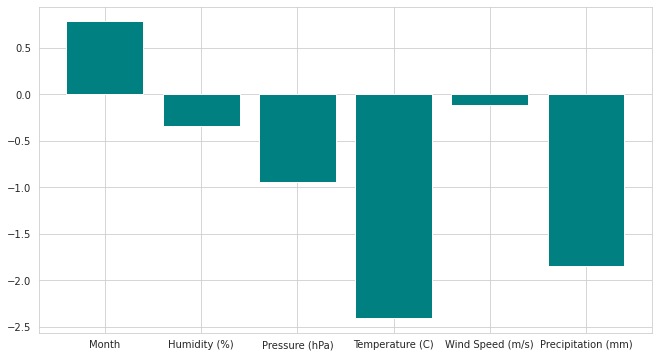

In [206]:
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train)
y_predicted = model.predict(x_test)
model_evaluation(y_test, y_predicted, x_train.shape[0], x_train.shape[1])
print()
plt.figure(figsize=(11,6))
sb.set_style("whitegrid")
plt.bar(x.columns, model.coef_, color = "teal")
plt.savefig("coeffsSimple.png")
print("Koeficijenti :", model.coef_)

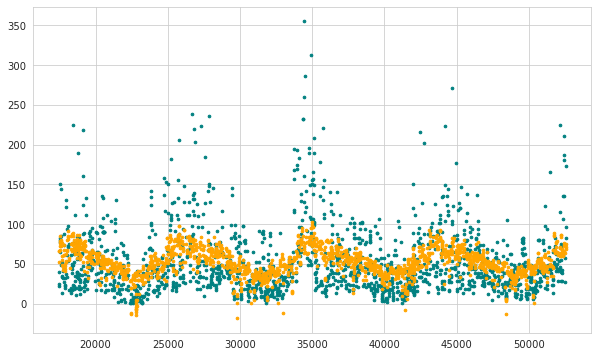

In [207]:
plt.figure(figsize=(10,6))
plt.scatter(x_test.index, y_test, s=7, c="teal")
plt.scatter(x_test.index, y_predicted, s=7, c="orange")
plt.savefig("scatterSimple.png")

Mean squared error:  1208.9486227602704
Mean absolute error:  24.693789399216236
Root mean squared error:  34.769938492327974
R2 score:  0.28430139312244507
R2 adjusted score:  0.2837220711897884
        y     y_pred
0   101.0  60.826941
1    31.0  32.478113
2     2.0  34.941792
3   101.0  42.172150
4    26.0  20.649181
5    24.0  35.143951
6    80.0  85.146311
7    37.0  32.020456
8    30.0  48.042638
9    41.0  79.133622
10   20.0  47.076312
11   12.0   2.769596
12   20.0  31.766460
13   17.0  54.950108
14   55.0  75.912581
15   71.0  78.976533
16   28.0  75.533506
17   90.0  59.440342
18   25.0  55.540267
19   38.0  53.448288
Koeficijenti : [ -7.45868664  -4.59867917 -11.94655539  -7.57855963 -11.90573626
  -9.6407648   22.64381437  -0.74762716  -3.63682446 -11.61868855
   1.81870468  -3.00200661  -2.2449972    3.62187806  -1.13348197
  -1.35714189   2.86400116  -1.44378109   2.16411909  -0.75320132
   1.13338354  -0.47053845  -0.25443454   9.13474215   1.40357333
   0.34993769   0.

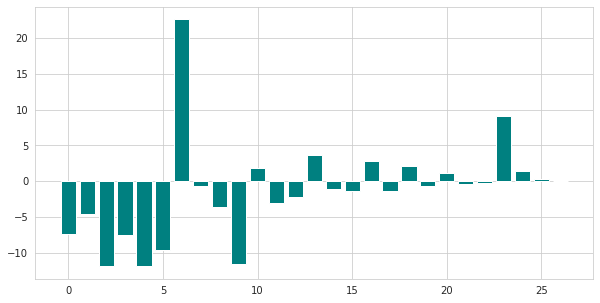

In [208]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_std = scaler.transform(x_train)
x_test_std = scaler.transform(x_test)
x_train_std = pd.DataFrame(x_train_std)
x_test_std = pd.DataFrame(x_test_std)
x_train_std.columns = list(x.columns)
x_test_std.columns = list(x.columns)

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
# Sa interaction_only = False ubacamo i kvadratne parametre u funkciju
x_inter_train = poly.fit_transform(x_train_std)
x_inter_test = poly.transform(x_test_std)

ridge_model = Ridge(alpha=5)
ridge_model.fit(x_inter_train, y_train)
y_predicted = ridge_model.predict(x_inter_test)
model_evaluation(y_test, y_predicted, x_inter_train.shape[0], x_inter_train.shape[1])
plt.figure(figsize=(10,5))
sb.set_style("whitegrid")
plt.bar(range(len(ridge_model.coef_)),ridge_model.coef_, color="teal")
plt.savefig("coeffsRidge.png")
print("Koeficijenti :", ridge_model.coef_)

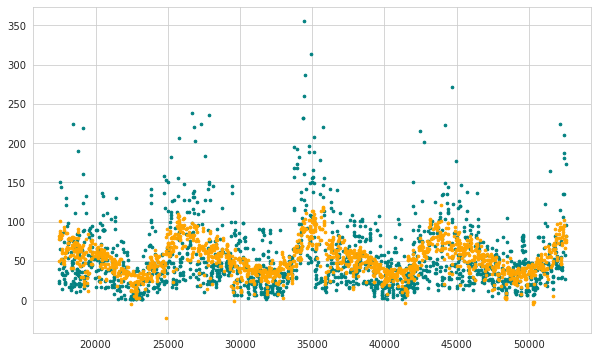

In [209]:
plt.figure(figsize=(10,6))
plt.scatter(x_test.index, y_test, s=7, c="teal")
plt.scatter(x_test.index, y_predicted, s=7, c="orange")
plt.savefig("scatterRidge.png")